### Importing package

In [1]:
# Libraries
import time
import re

# Reading in files
import pandas as pd
import numpy as np
import pickle
import gzip

# Progress bar
from tqdm.auto import tqdm

# Torch modules
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

# Lightning modules
import pytorch_lightning as pl
from torchmetrics.functional import accuracy, auroc
from torchmetrics import F1Score
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall

# Split dataset/validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.model_selection import StratifiedKFold

# Importing own functions 
from importing_data import get_section_json

C:\Users\Benjamin Aw\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with gzip.open("data/acl-publication-info.74k.v2.full-sections.pkl", "rb") as f:
    df = pickle.load(f, encoding='bytes')

In [3]:
df = df.reset_index()

In [4]:
df["Intro_concl"] = df['json_contents'].progress_apply(get_section_json, args = [["introduction", "conclusion"]])

100%|█████████████████████████████████████████████████████████████████████████| 67732/67732 [00:00<00:00, 68554.69it/s]


In [5]:
df2 = pd.json_normalize(df['Intro_concl'])

In [6]:
df["Intro_concl_concat"] = df2['Introduction'] + df2['Conclusion'] 

In [7]:
df["Year Published"] = df["ID"].apply(lambda x: re.search("\d{4}", x).group(0))

### Importing classification model

In [8]:
train_df = pd.read_csv("./Data/Collated_dataset_for_scientific_papers.csv")

In [9]:
train_df = train_df[["Intro Concl", "Labels"]]

In [10]:
train_df.columns = ["string", "label"]

In [11]:
possible_labels = list(train_df['label'].unique())
possible_labels_num = list(range(0,len(possible_labels)))

In [12]:
MODEL_NAME = 'allenai/specter'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [13]:
mapping = zip(possible_labels, possible_labels_num)
label_to_idx = {label: num  for label, num in mapping}
mapping = zip(possible_labels, possible_labels_num)
idx_to_label = {num: label for label, num in mapping}

In [14]:
MAX_TOKEN_COUNT = 512
N_EPOCHS = 5
BATCH_SIZE = 8 # Changes: Edit the batch size here
KFOLD = 5

In [15]:
class SpecterDataset(Dataset):
    
    def __init__(self, data: pd.DataFrame, tokenizer: AutoTokenizer, max_token_len: int = MAX_TOKEN_COUNT, mapping = label_to_idx):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
        self.mapping = mapping
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index: int):
    
        data_row = self.data.iloc[index]
        text = data_row["string"]
        labels = self.mapping[data_row["label"]]

        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_token_len,
          return_token_type_ids=False,
          padding="max_length",
          truncation=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return dict(
          text=text,
          input_ids=encoding["input_ids"].flatten(),
          attention_mask=encoding["attention_mask"].flatten(),
          labels=labels
        )

In [16]:
class SpecterDataModule(pl.LightningDataModule):
    
    def __init__(self, df,
                 tokenizer,
                 k = 0,  # fold number
                 split_seed = 123,  # split needs to be always the same for correct cross validation
                 num_splits = KFOLD,
                 batch_size = BATCH_SIZE, 
                 max_token_len = MAX_TOKEN_COUNT,
                 num_workers = 0,
                 pin_memory = False):
        
        super().__init__()

        self.save_hyperparameters(logger=False)
    
    def setup(self, stage=None):

        # choose fold to train on
        kf = StratifiedKFold(n_splits=self.hparams.num_splits, shuffle=True, random_state=self.hparams.split_seed)
        all_splits = [k for k in kf.split(df, df.label)]
        train_indexes, val_indexes = all_splits[self.hparams.k]
        train_indexes, val_indexes = train_indexes.tolist(), val_indexes.tolist()

        self.data_train, self.data_val = df.iloc[train_indexes], df.iloc[val_indexes]
        
        self.train_dataset = SpecterDataset(
          self.data_train,
          self.hparams.tokenizer,
          self.hparams.max_token_len
        )
        self.val_dataset = SpecterDataset(
          self.data_val,
          self.hparams.tokenizer,
          self.hparams.max_token_len
        )
        
    def train_dataloader(self):
        return DataLoader(
          self.train_dataset,
          batch_size = self.hparams.batch_size,
          shuffle=True
        )
    
    def val_dataloader(self):
        return DataLoader(
          self.val_dataset,
          batch_size = self.hparams.batch_size
        )

### Modelling

In [17]:
class SpecterClassModel(pl.LightningModule):
    
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    
        super().__init__()
        self.specter = AutoModel.from_pretrained(MODEL_NAME, return_dict=True)
        # Changes: Edit model architecture forward pass here
        self.classifier = nn.Linear(self.specter.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.CrossEntropyLoss()
        self.acc = MulticlassAccuracy(num_classes = 21, average = 'weighted') #measure performance based on weighted average
        self.f1 = MulticlassF1Score(num_classes = 21, average = 'weighted')
        self.prec = MulticlassPrecision(num_classes = 21, average = 'weighted')
        self.rec = MulticlassRecall(num_classes = 21, average = 'weighted')
        
        # Changes: Comment below code to remove freezing of the SPECTER embeddings
        for name, param in self.specter.named_parameters():
            if name.startswith('embeddings'):
                param.requires_grad = False
    
    
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.specter(input_ids, attention_mask=attention_mask)
        # Changes: Edit model architecture forward pass here
        output = self.classifier(output.pooler_output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
            # acc = self.acc(output, labels)
            # f1 = self.f1(output, labels)
            # prec = self.prec(output, labels)
            # rec = self.rec(output, labels)
        return loss, output #, acc, f1, prec, rec

    
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        #loss, output, acc, f1, prec, rec = self(input_ids, attention_mask, labels)
        loss, output = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": output, "labels": labels}

    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        #loss, output, acc, f1, prec, rec = self(input_ids, attention_mask, labels)
        loss, output = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": output, "labels": labels}
    
    def training_epoch_end(self, outputs):
        avg_loss = sum(output['loss'].item() for output in outputs) / len(outputs)
        
        predictions = torch.cat([output['predictions'] for output in outputs])
        labels = torch.cat([output['labels'] for output in outputs])
        
        acc = self.acc(predictions, labels)
        f1 = self.f1(predictions, labels)
        prec = self.prec(predictions, labels)
        rec = self.rec(predictions, labels)
        print(f"******Train epoch {self.current_epoch} eval metrics: loss {avg_loss:.8f}, f1 {f1:.4f} prec {prec:.4f} rec {rec:.4f}, acc {acc:.4f}")
        
        self.logger.experiment.add_scalars('loss', {'train': avg_loss}, self.current_epoch)    
    
    def validation_epoch_end(self, outputs):
        avg_loss = sum(output['loss'].item() for output in outputs) / len(outputs)

        predictions = torch.cat([output['predictions'] for output in outputs])
        labels = torch.cat([output['labels'] for output in outputs])
        
        acc = self.acc(predictions, labels)
        f1 = self.f1(predictions, labels)
        prec = self.prec(predictions, labels)
        rec = self.rec(predictions, labels)
        print(f"******Val epoch {self.current_epoch} eval metrics: loss {avg_loss:.8f}, f1 {f1:.4f} prec {prec:.4f} rec {rec:.4f}, acc {acc:.4f}")
        
        #For final output
        self.log("Ignore/acc", acc, logger=True)
        self.log("Ignore/f1", f1, logger=True)
        self.log("Ignore/prec", prec, logger=True)
        self.log("Ignore/rec", rec, logger=True)
        
        #For Tensorboard visualisaion with Epoch as x axis
        self.logger.experiment.add_scalar('Collated/acc', acc, self.current_epoch)
        self.logger.experiment.add_scalar('Collated/f1', f1, self.current_epoch)
        self.logger.experiment.add_scalar('Collated/prec', prec, self.current_epoch)
        self.logger.experiment.add_scalar('Collated/rec', rec, self.current_epoch)
    
        self.logger.experiment.add_scalars('loss', {'val': avg_loss}, self.current_epoch)
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5) # Changes: Edit the learning rate
        scheduler = get_linear_schedule_with_warmup( # Changes: Edit the scheduler
          optimizer,
          num_warmup_steps=self.n_warmup_steps,
          num_training_steps=self.n_training_steps
        )
        
        # Changes: Edit the optimizer
        return dict(
          optimizer = optimizer,
          lr_scheduler = dict(
            scheduler = scheduler,
            interval = 'step'
          )
        )

In [18]:
trained_model = SpecterClassModel.load_from_checkpoint(
  './Experiments/checkpoints/best-checkpoint-Default.ckpt',
  n_classes = 21
)

trained_model.eval()
trained_model.freeze()

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

In [20]:
df_for_pred = df[['Intro_concl_concat']]

In [21]:
df_for_pred['label'] = "Summarization"

C:\Users\Benjamin Aw\AppData\Local\Temp\ipykernel_5688\2342050073.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_pred['label'] = "Summarization"


In [22]:
df_for_pred.columns = ("string", "label")

In [23]:
pred_dataset = SpecterDataset(
    df_for_pred,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(pred_dataset):
    
    _, prediction = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device)
    )
    
    predictions.append(prediction.flatten())
    labels.append(item["labels"])

predictions = torch.stack(predictions).detach().cpu()
labels = torch.IntTensor(labels).detach().cpu()

100%|████████████████████████████████████████████████████████████████████████████| 67732/67732 [12:33<00:00, 89.85it/s]


In [24]:
labelled_prediction = [idx_to_label[pred] for pred in torch.argmax(predictions, dim=1).tolist()]

In [25]:
df["Model Predicted Topics"] = labelled_prediction

### Finding out emerging topics

In [26]:
emerge_df = df[["Year Published", "Model Predicted Topics"]]

In [27]:
emerge_df

Year Published                             Model Predicted Topics
0               2013                           Resources and Evaluation
1               2005            Machine Translation and Multilinguality
2               2013  Semantics: Sentence-level Semantics, Textual I...
3               2005            Machine Translation and Multilinguality
4               2013        Phonology, Morphology and Word Segmentation
...              ...                                                ...
67727           1999                           Speech and Multimodality
67728           2000              Syntax: Tagging, Chunking and Parsing
67729           1999  Linguistic Theories, Cognitive Modeling and Ps...
67730           1999                       Semantics: Lexical Semantics
67731           2000                   Dialogue and Interactive Systems

[67732 rows x 2 columns]

In [28]:
year_topic_count = emerge_df.groupby(['Year Published', 'Model Predicted Topics']).size()

In [29]:
year_topic_count = year_topic_count.reset_index(name='Topic Count')

In [30]:
year_topic_count

Year Published                             Model Predicted Topics  \
0             1952  Language Grounding to Vision, Robotics and Beyond   
1             1956  Language Grounding to Vision, Robotics and Beyond   
2             1957  Language Grounding to Vision, Robotics and Beyond   
3             1960  Language Grounding to Vision, Robotics and Beyond   
4             1960                           Resources and Evaluation   
..             ...                                                ...   
820           2022  Semantics: Sentence-level Semantics, Textual I...   
821           2022  Sentiment Analysis, Stylistic Analysis, and Ar...   
822           2022                           Speech and Multimodality   
823           2022                                      Summarization   
824           2022              Syntax: Tagging, Chunking and Parsing   

     Topic Count  
0             18  
1             10  
2              5  
3             14  
4              1  
..           ...  
820          145  
821          124  
822          114  
823           85  
824           32  

[825 rows x 3 columns]

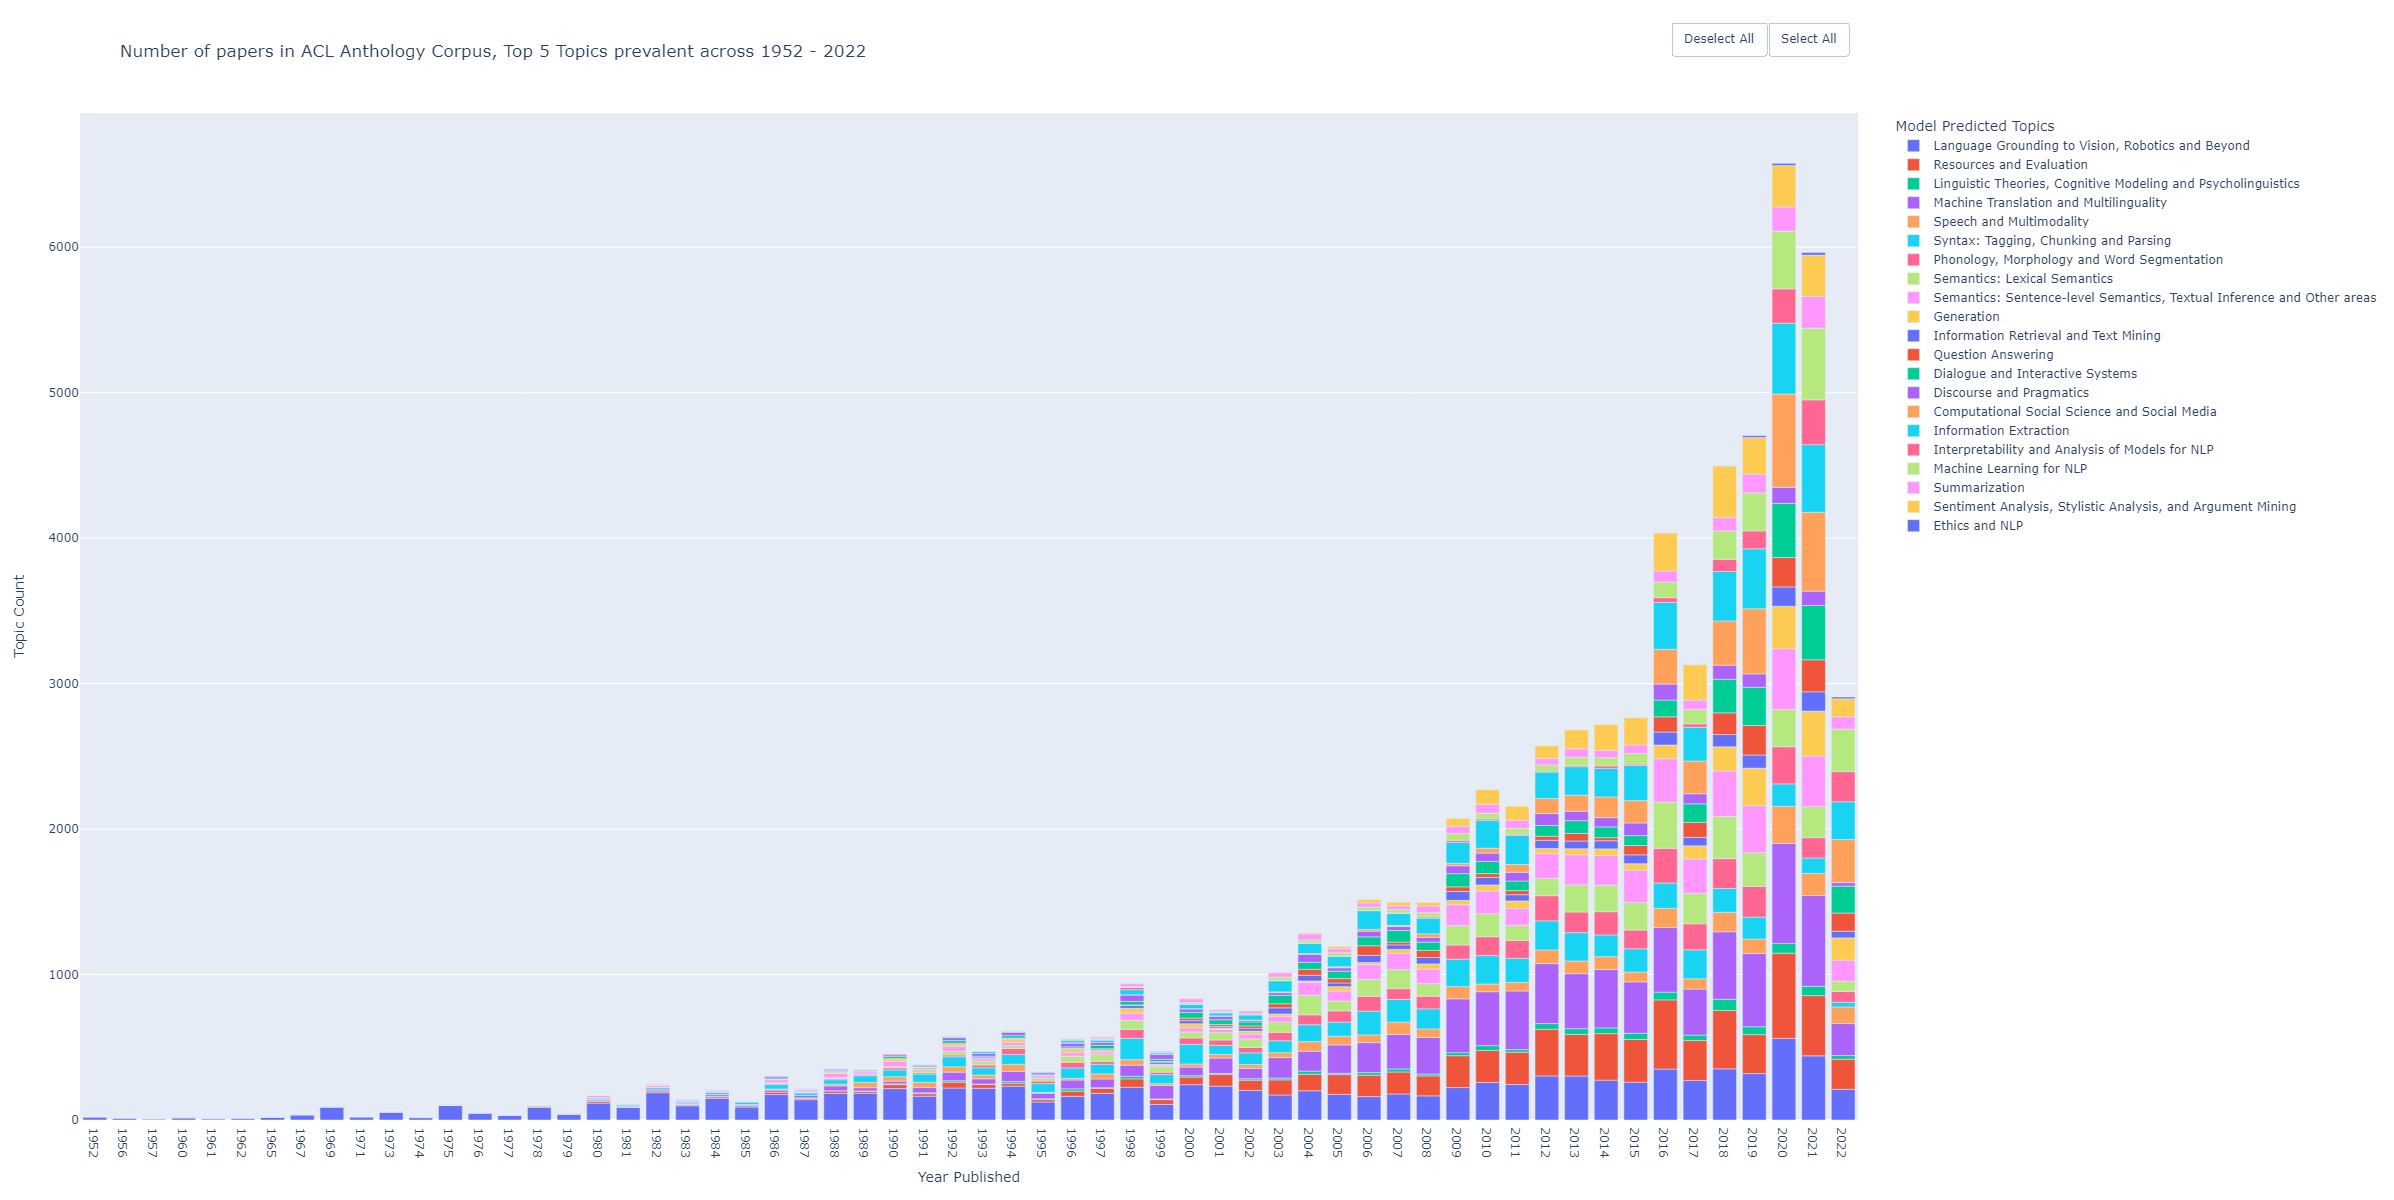

In [31]:
import plotly.express as px

fig = px.bar(year_topic_count, x="Year Published", y="Topic Count", color="Model Predicted Topics", title="Number of papers in ACL Anthology Corpus, Top 5 Topics prevalent across 1952 - 2022",
             width=1800, height=1200)

fig.update_layout(dict(updatemenus=[
                        dict(
                            type = "buttons",
                            direction = "left",
                            buttons=list([
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle"
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle"
                                )
                            ]),
                            pad={"r": 10, "t": 10},
                            showactive=False,
                            x=1,
                            xanchor="right",
                            y=1.1,
                            yanchor="top"
                        ),
                    ]
              ))

fig.show()

### Chosing the top 5 topics to display

In [32]:
year_topic_count.groupby(['Model Predicted Topics']).size().reset_index(name='Topic Appearance ac years').sort_values(by = "Topic Appearance ac years", ascending = False)

Model Predicted Topics  \
8   Language Grounding to Vision, Robotics and Beyond   
14                           Resources and Evaluation   
16  Semantics: Sentence-level Semantics, Textual I...   
20              Syntax: Tagging, Chunking and Parsing   
11            Machine Translation and Multilinguality   
9   Linguistic Theories, Cognitive Modeling and Ps...   
4                                          Generation   
1                    Dialogue and Interactive Systems   
12        Phonology, Morphology and Word Segmentation   
15                       Semantics: Lexical Semantics   
2                            Discourse and Pragmatics   
18                           Speech and Multimodality   
7     Interpretability and Analysis of Models for NLP   
13                                 Question Answering   
5                              Information Extraction   
10                           Machine Learning for NLP   
6               Information Retrieval and Text Mining   
19                                      Summarization   
0       Computational Social Science and Social Media   
17  Sentiment Analysis, Stylistic Analysis, and Ar...   
3                                      Ethics and NLP   

    Topic Appearance ac years  
8                          60  
14                         52  
16                         50  
20                         48  
11                         46  
9                          45  
4                          43  
1                          43  
12                         43  
15                         42  
2                          42  
18                         40  
7                          38  
13                         36  
5                          35  
10                         34  
6                          34  
19                         31  
0                          30  
17                         26  
3                           7

In [33]:
top_5_topics = list(year_topic_count.groupby(['Model Predicted Topics']).size().reset_index(name='Topic Appearance ac years').sort_values(by = "Topic Appearance ac years", ascending = False)['Model Predicted Topics'][0:5])

C:\Users\Benjamin Aw\AppData\Local\Temp\ipykernel_5688\1788818505.py:1: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [34]:
df_plot_1 = year_topic_count[year_topic_count['Model Predicted Topics'].isin(top_5_topics)]

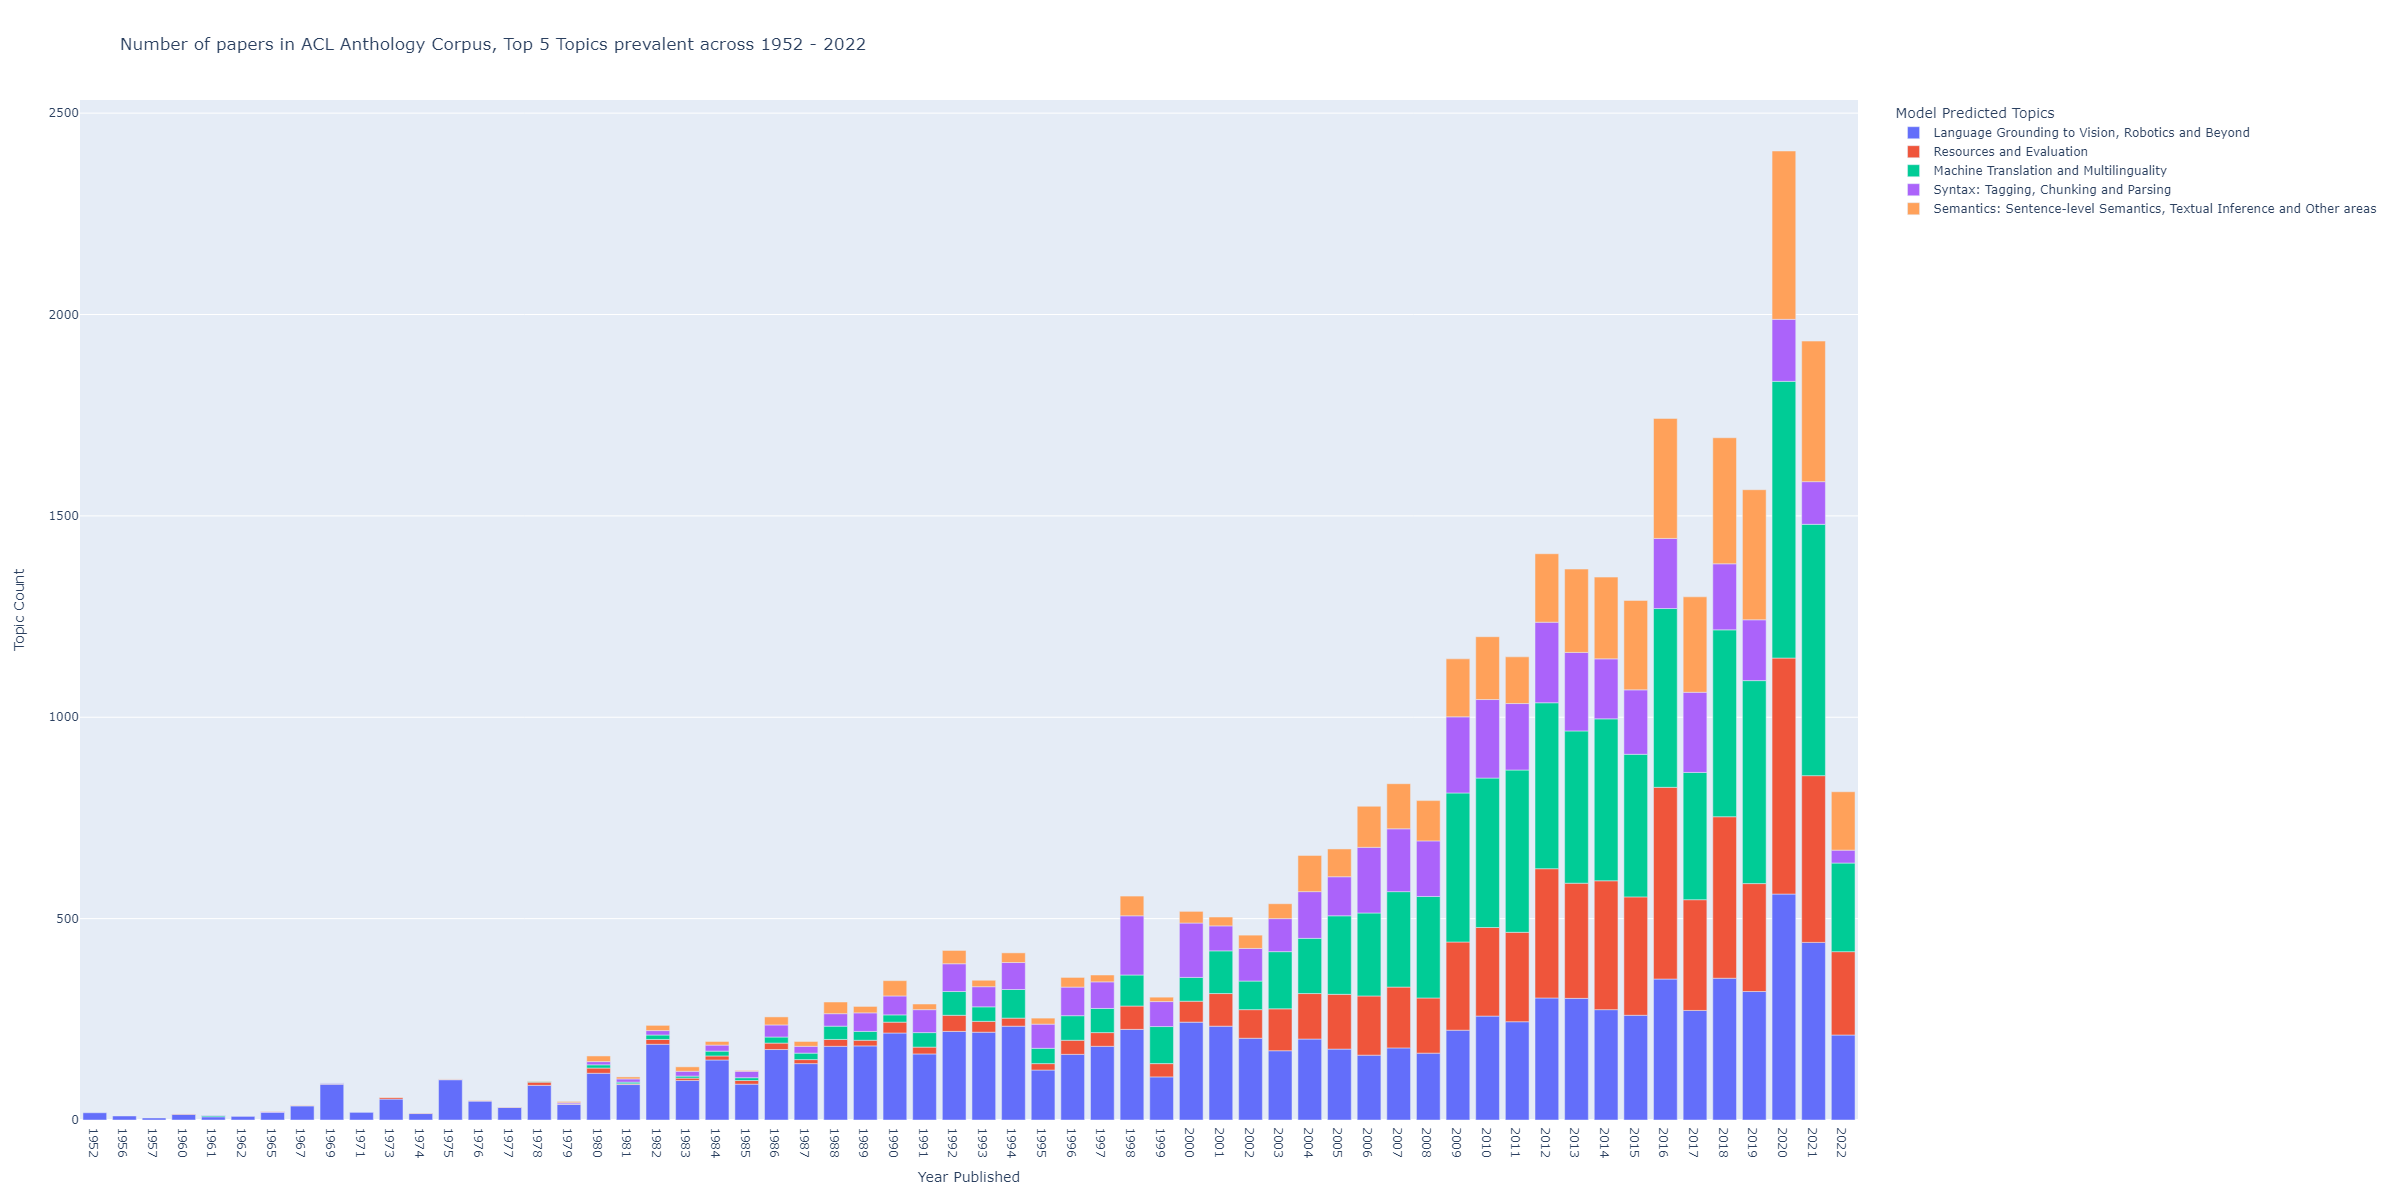

In [35]:
import plotly.express as px

fig = px.bar(df_plot_1, x="Year Published", y="Topic Count", color="Model Predicted Topics", title="Number of papers in ACL Anthology Corpus, Top 5 Topics prevalent across 1952 - 2022",
             width=1800, height=1200)
fig.show()

### Calculating burstiness of a topic

In [36]:
# Rolling window of t-k to t+k
k = 2

# rolling(k*2+1, min_periods = 1, center = True)

In [37]:
year_topic_count['Year Published'] = year_topic_count['Year Published'].astype(int)

In [38]:
# Filtering year from 2000 to to 2021
f_c_t = year_topic_count[(year_topic_count['Year Published'] > 1999) & (year_topic_count['Year Published'] < 2022)]

In [40]:
N_t = f_c_t.groupby('Year Published')['Topic Count'].sum()

In [41]:
N_t = N_t.reset_index(name='Paper Count')

In [43]:
f_c_t = emerge_df.groupby(['Year Published', 'Model Predicted Topics']).size().unstack(fill_value=0).stack()

In [44]:
f_c_t = f_c_t.reset_index(name='Topic Count')

In [45]:
f_c_t['Year Published'] = f_c_t['Year Published'].astype(int)
f_c_t = f_c_t[(f_c_t['Year Published'] > 1999) & (f_c_t['Year Published'] < 2022)]

Year Published                             Model Predicted Topics  \
777             2000      Computational Social Science and Social Media   
778             2000                   Dialogue and Interactive Systems   
779             2000                           Discourse and Pragmatics   
780             2000                                     Ethics and NLP   
781             2000                                         Generation   
...              ...                                                ...   
1234            2021  Semantics: Sentence-level Semantics, Textual I...   
1235            2021  Sentiment Analysis, Stylistic Analysis, and Ar...   
1236            2021                           Speech and Multimodality   
1237            2021                                      Summarization   
1238            2021              Syntax: Tagging, Chunking and Parsing   

      Topic Count  
777             1  
778            40  
779            24  
780             0  
781            28  
...           ...  
1234          349  
1235          284  
1236          152  
1237          218  
1238          106  

[462 rows x 3 columns]

In [46]:
f_c_t = f_c_t.sort_values(['Model Predicted Topics', 'Year Published'])

Year Published                         Model Predicted Topics  \
777             2000  Computational Social Science and Social Media   
798             2001  Computational Social Science and Social Media   
819             2002  Computational Social Science and Social Media   
840             2003  Computational Social Science and Social Media   
861             2004  Computational Social Science and Social Media   
...              ...                                            ...   
1154            2017          Syntax: Tagging, Chunking and Parsing   
1175            2018          Syntax: Tagging, Chunking and Parsing   
1196            2019          Syntax: Tagging, Chunking and Parsing   
1217            2020          Syntax: Tagging, Chunking and Parsing   
1238            2021          Syntax: Tagging, Chunking and Parsing   

      Topic Count  
777             1  
798             2  
819             1  
840             6  
861             5  
...           ...  
1154          199  
1175          164  
1196          151  
1217          154  
1238          106  

[462 rows x 3 columns]

In [47]:
pc = f_c_t.groupby('Model Predicted Topics')['Topic Count'].rolling(k*2+1, min_periods = 1, center = True).sum().reset_index(name='Sliding sum of topic count')

In [48]:
year_idx_mapping = f_c_t['Year Published'].reset_index(name='Year Published')

In [49]:
pc = pc.merge(year_idx_mapping, left_on = 'level_1', right_on = 'index', how = 'inner').drop(['level_1', 'index'], axis = 1)
pc = pc[["Year Published", "Model Predicted Topics", "Sliding sum of topic count"]]

In [50]:
N_t['Sliding sum of total paper count'] = N_t['Paper Count'].rolling(k*2+1, min_periods = 1, center = True).sum()

In [51]:
pc = pc.merge(N_t, on = 'Year Published', how = 'left')

In [52]:
pc['Pc'] = pc['Sliding sum of topic count'] / pc['Sliding sum of total paper count']

In [53]:
#This gives me N_t [Paper Count](total number of papers published per year), f_c_t [Topic Count](paper of a particular topic published per year) and p_c [Pc](expected probability count for topic per year)
f_c_t = f_c_t.merge(pc, on = ['Year Published', 'Model Predicted Topics'], how = 'left')

In [66]:
z_c_t = f_c_t.copy()
z_c_t["Expected value"] = z_c_t['Paper Count'] * z_c_t['Pc']
z_c_t["SD value"] = (z_c_t['Paper Count'] * z_c_t['Pc'] * (1 - z_c_t['Pc']))**(1/2)

In [67]:
z_c_t['Zct'] = (z_c_t['Topic Count'] - z_c_t['Expected value'])/z_c_t['SD value']

In [68]:
df_plot_2 = z_c_t.sort_values(['Year Published','Zct'],ascending=[True, False]).groupby('Year Published')['Year Published', 'Model Predicted Topics', 'Zct'].head(5)

C:\Users\Benjamin Aw\AppData\Local\Temp\ipykernel_5688\2116979918.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [85]:
z_c_t['Zct'] = z_c_t['Zct'].fillna(0)

In [86]:
z_c_t = z_c_t.sort_values(by="Year Published")

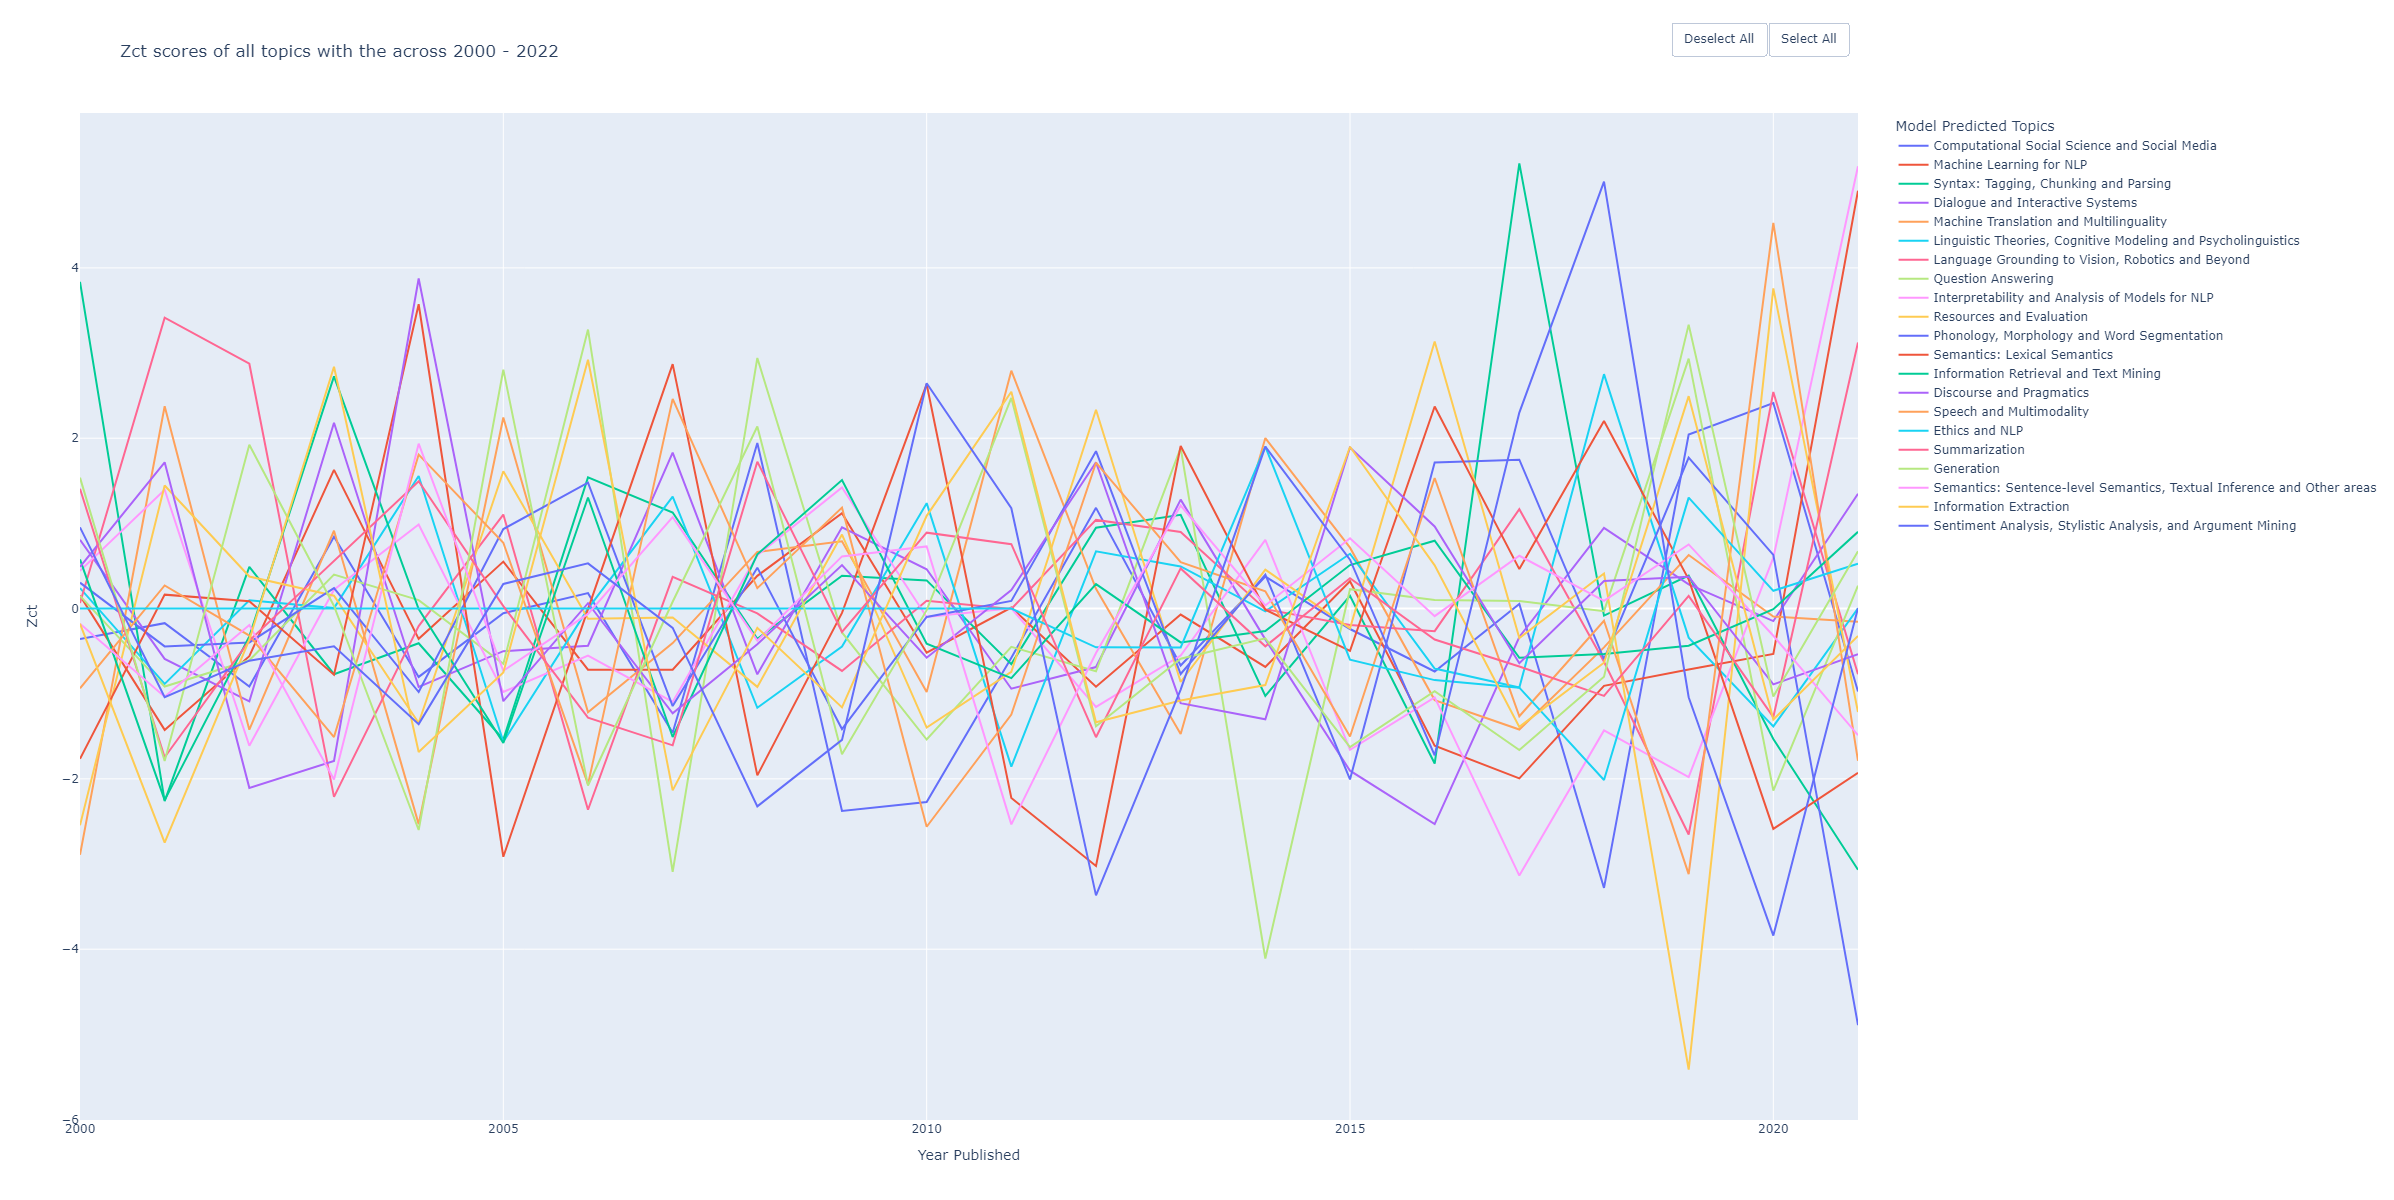

In [87]:
import plotly.express as px

fig = px.line(z_c_t, x="Year Published", y="Zct", color="Model Predicted Topics", title="Zct scores of all topics with the across 2000 - 2022",
             width=1800, height=1200)

fig.update_layout(dict(updatemenus=[
                        dict(
                            type = "buttons",
                            direction = "left",
                            buttons=list([
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle"
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle"
                                )
                            ]),
                            pad={"r": 10, "t": 10},
                            showactive=False,
                            x=1,
                            xanchor="right",
                            y=1.1,
                            yanchor="top"
                        ),
                    ]
              ))

fig.show()

In [88]:
z_c_t['Model Predicted Topics'].unique()

array(['Computational Social Science and Social Media',
       'Machine Learning for NLP',
       'Syntax: Tagging, Chunking and Parsing',
       'Dialogue and Interactive Systems',
       'Machine Translation and Multilinguality',
       'Linguistic Theories, Cognitive Modeling and Psycholinguistics',
       'Language Grounding to Vision, Robotics and Beyond',
       'Question Answering',
       'Interpretability and Analysis of Models for NLP',
       'Resources and Evaluation',
       'Phonology, Morphology and Word Segmentation',
       'Semantics: Lexical Semantics',
       'Information Retrieval and Text Mining',
       'Discourse and Pragmatics', 'Speech and Multimodality',
       'Ethics and NLP', 'Summarization', 'Generation',
       'Semantics: Sentence-level Semantics, Textual Inference and Other areas',
       'Information Extraction',
       'Sentiment Analysis, Stylistic Analysis, and Argument Mining'],
      dtype=object)

In [89]:
z_c_t[z_c_t['Model Predicted Topics'] == 'Discourse and Pragmatics']

Year Published    Model Predicted Topics  Topic Count  \
44            2000  Discourse and Pragmatics           24   
45            2001  Discourse and Pragmatics           25   
46            2002  Discourse and Pragmatics           12   
47            2003  Discourse and Pragmatics           18   
48            2004  Discourse and Pragmatics           55   
49            2005  Discourse and Pragmatics           24   
50            2006  Discourse and Pragmatics           39   
51            2007  Discourse and Pragmatics           27   
52            2008  Discourse and Pragmatics           33   
53            2009  Discourse and Pragmatics           54   
54            2010  Discourse and Pragmatics           57   
55            2011  Discourse and Pragmatics           60   
56            2012  Discourse and Pragmatics           82   
57            2013  Discourse and Pragmatics           65   
58            2014  Discourse and Pragmatics           64   
59            2015  Discourse and Pragmatics           87   
60            2016  Discourse and Pragmatics          110   
61            2017  Discourse and Pragmatics           69   
62            2018  Discourse and Pragmatics           97   
63            2019  Discourse and Pragmatics           92   
64            2020  Discourse and Pragmatics          111   
65            2021  Discourse and Pragmatics           99   

    Sliding sum of topic count  Paper Count  Sliding sum of total paper count  \
44                        61.0          838                            2350.0   
45                        79.0          760                            3367.0   
46                       134.0          752                            4653.0   
47                       134.0         1017                            5008.0   
48                       148.0         1286                            5764.0   
49                       163.0         1193                            6510.0   
50                       178.0         1516                            6988.0   
51                       177.0         1498                            7774.0   
52                       210.0         1495                            8852.0   
53                       231.0         2072                            9493.0   
54                       286.0         2271                           10567.0   
55                       318.0         2157                           11754.0   
56                       328.0         2572                           12402.0   
57                       358.0         2682                           12897.0   
58                       408.0         2720                           14775.0   
59                       395.0         2766                           15335.0   
60                       427.0         4035                           17151.0   
61                       455.0         3132                           19136.0   
62                       479.0         4498                           22947.0   
63                       468.0         4705                           24876.0   
64                       399.0         6577                           21744.0   
65                       302.0         5964                           17246.0   

          Pc  Expected value   SD value       Zct  
44  0.025957       21.752340   4.603010  0.488302  
45  0.023463       17.831898   4.172950  1.717754  
46  0.028799       21.656566   4.586162 -2.105587  
47  0.026757       27.212061   5.146255 -1.790051  
48  0.025677       33.020125   5.672061  3.875112  
49  0.025038       29.870814   5.396563 -1.087880  
50  0.025472       38.615913   6.134515  0.062611  
51  0.022768       34.106766   5.773233 -1.230986  
52  0.023723       35.466561   5.884316 -0.419176  
53  0.024334       50.419467   7.013742  0.510503  
54  0.027065       61.465506   7.733170 -0.577448  
55  0.027055       58.356815   7.535117  0.218070  
56  0.026447       68.022577   8.137786  1.717595  
57  0.02

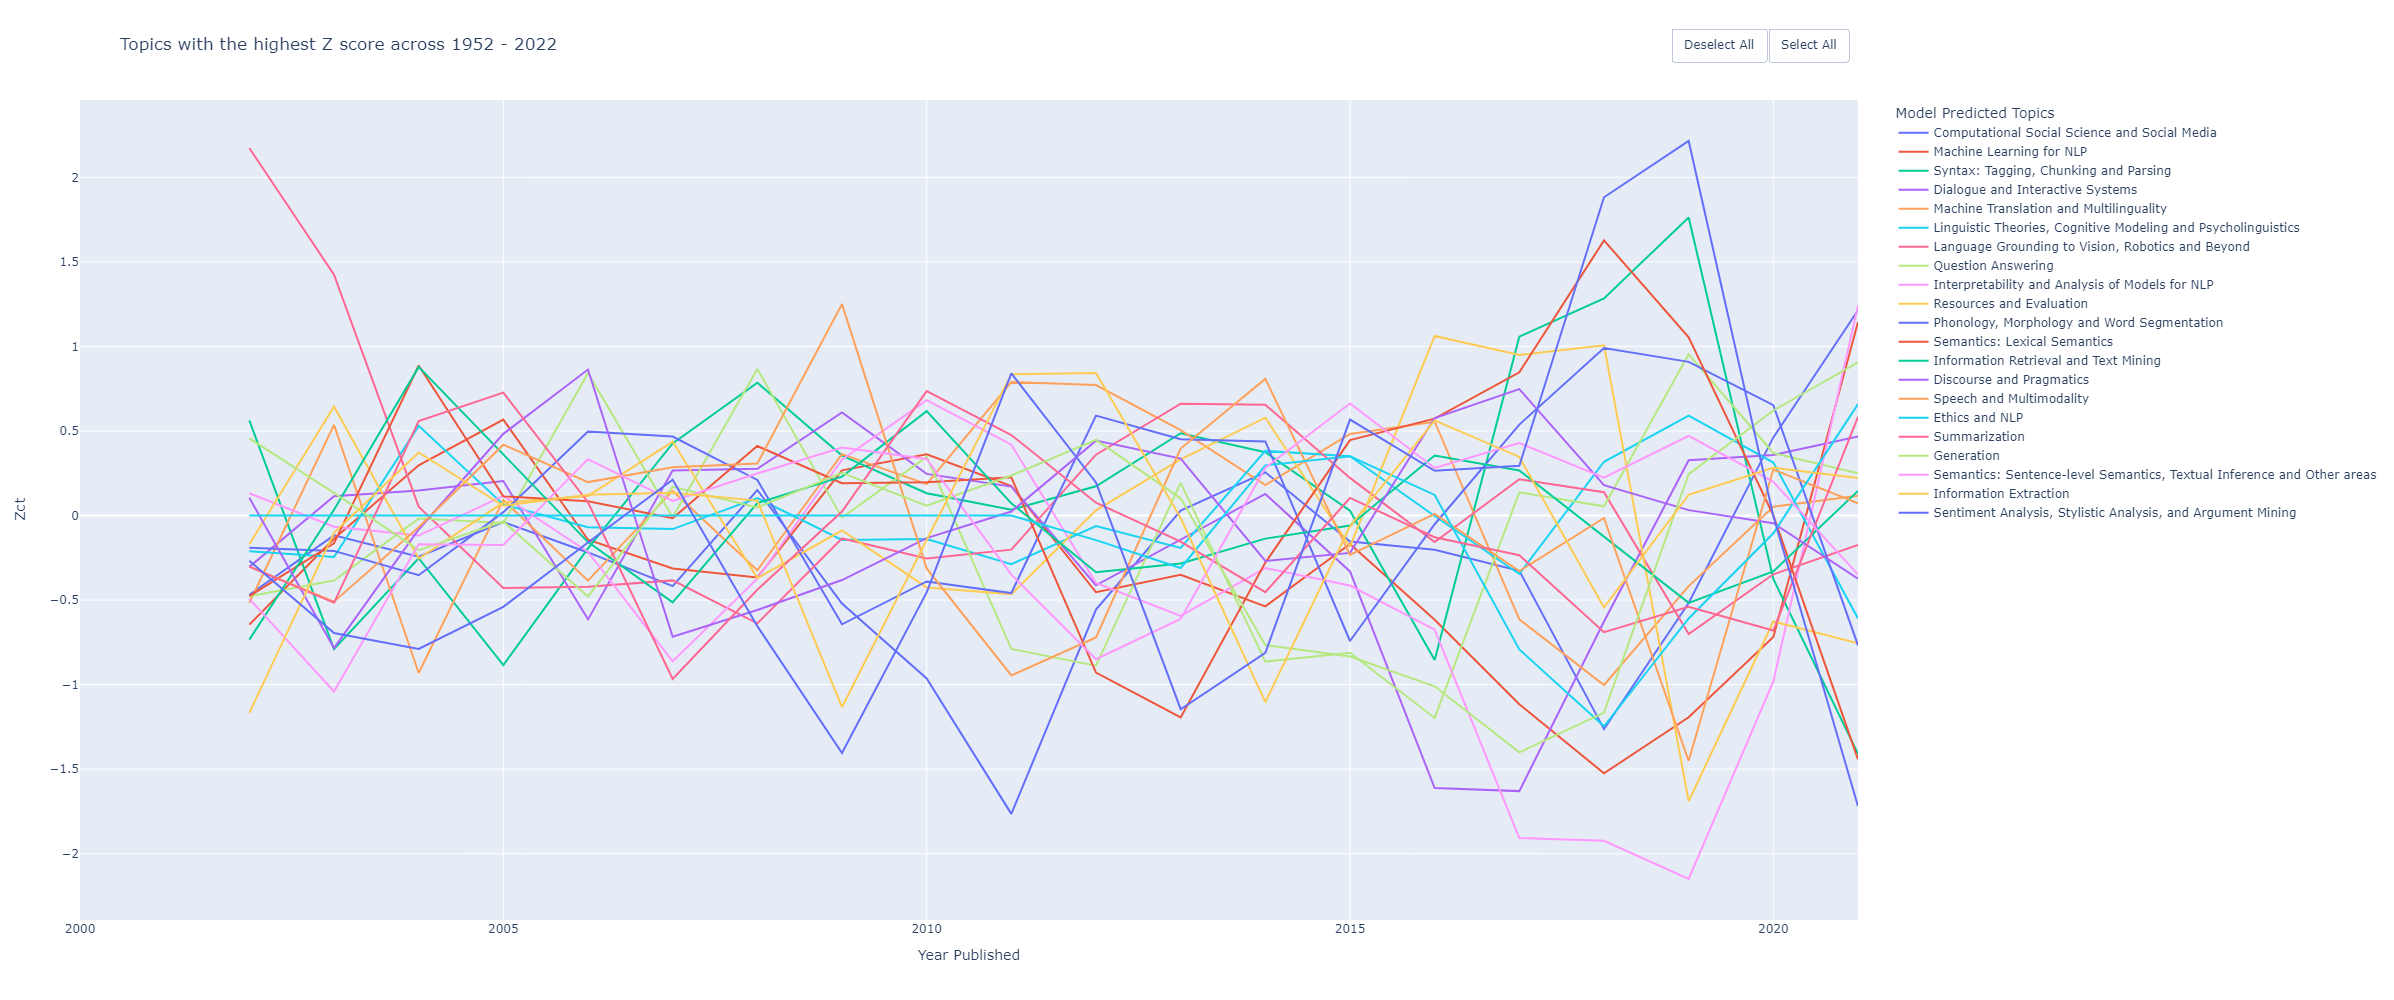

In [90]:
import plotly.express as px

fig = px.scatter(z_c_t, x="Year Published", y="Zct", color="Model Predicted Topics", title="Topics with the highest Z score across 1952 - 2022",
                 trendline="rolling", 
                 trendline_options=dict(window=3, win_type="gaussian", function_args=dict(std=2)),
                 width=2300,
                 height=1000)

fig.update_layout(dict(updatemenus=[
                        dict(
                            type = "buttons",
                            direction = "left",
                            buttons=list([
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle"
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle"
                                )
                            ]),
                            pad={"r": 10, "t": 10},
                            showactive=False,
                            x=1,
                            xanchor="right",
                            y=1.1,
                            yanchor="top"
                        ),
                    ]
              ))
fig.data = [t for t in fig.data if t.mode == "lines"]
fig.update_traces(showlegend=True)
fig.show()

### Plot top 5 topics with the widest z score with trendlines (gaussian rolling mean)

In [91]:
Topics_of_interest = list(z_c_t.groupby('Model Predicted Topics')['Zct'].agg(np.ptp).reset_index(name = "Diff z score").nlargest(5, "Diff z score")['Model Predicted Topics'])

In [92]:
pldf_plot_3 = z_c_t[z_c_t['Model Predicted Topics'].isin(Topics_of_interest)]

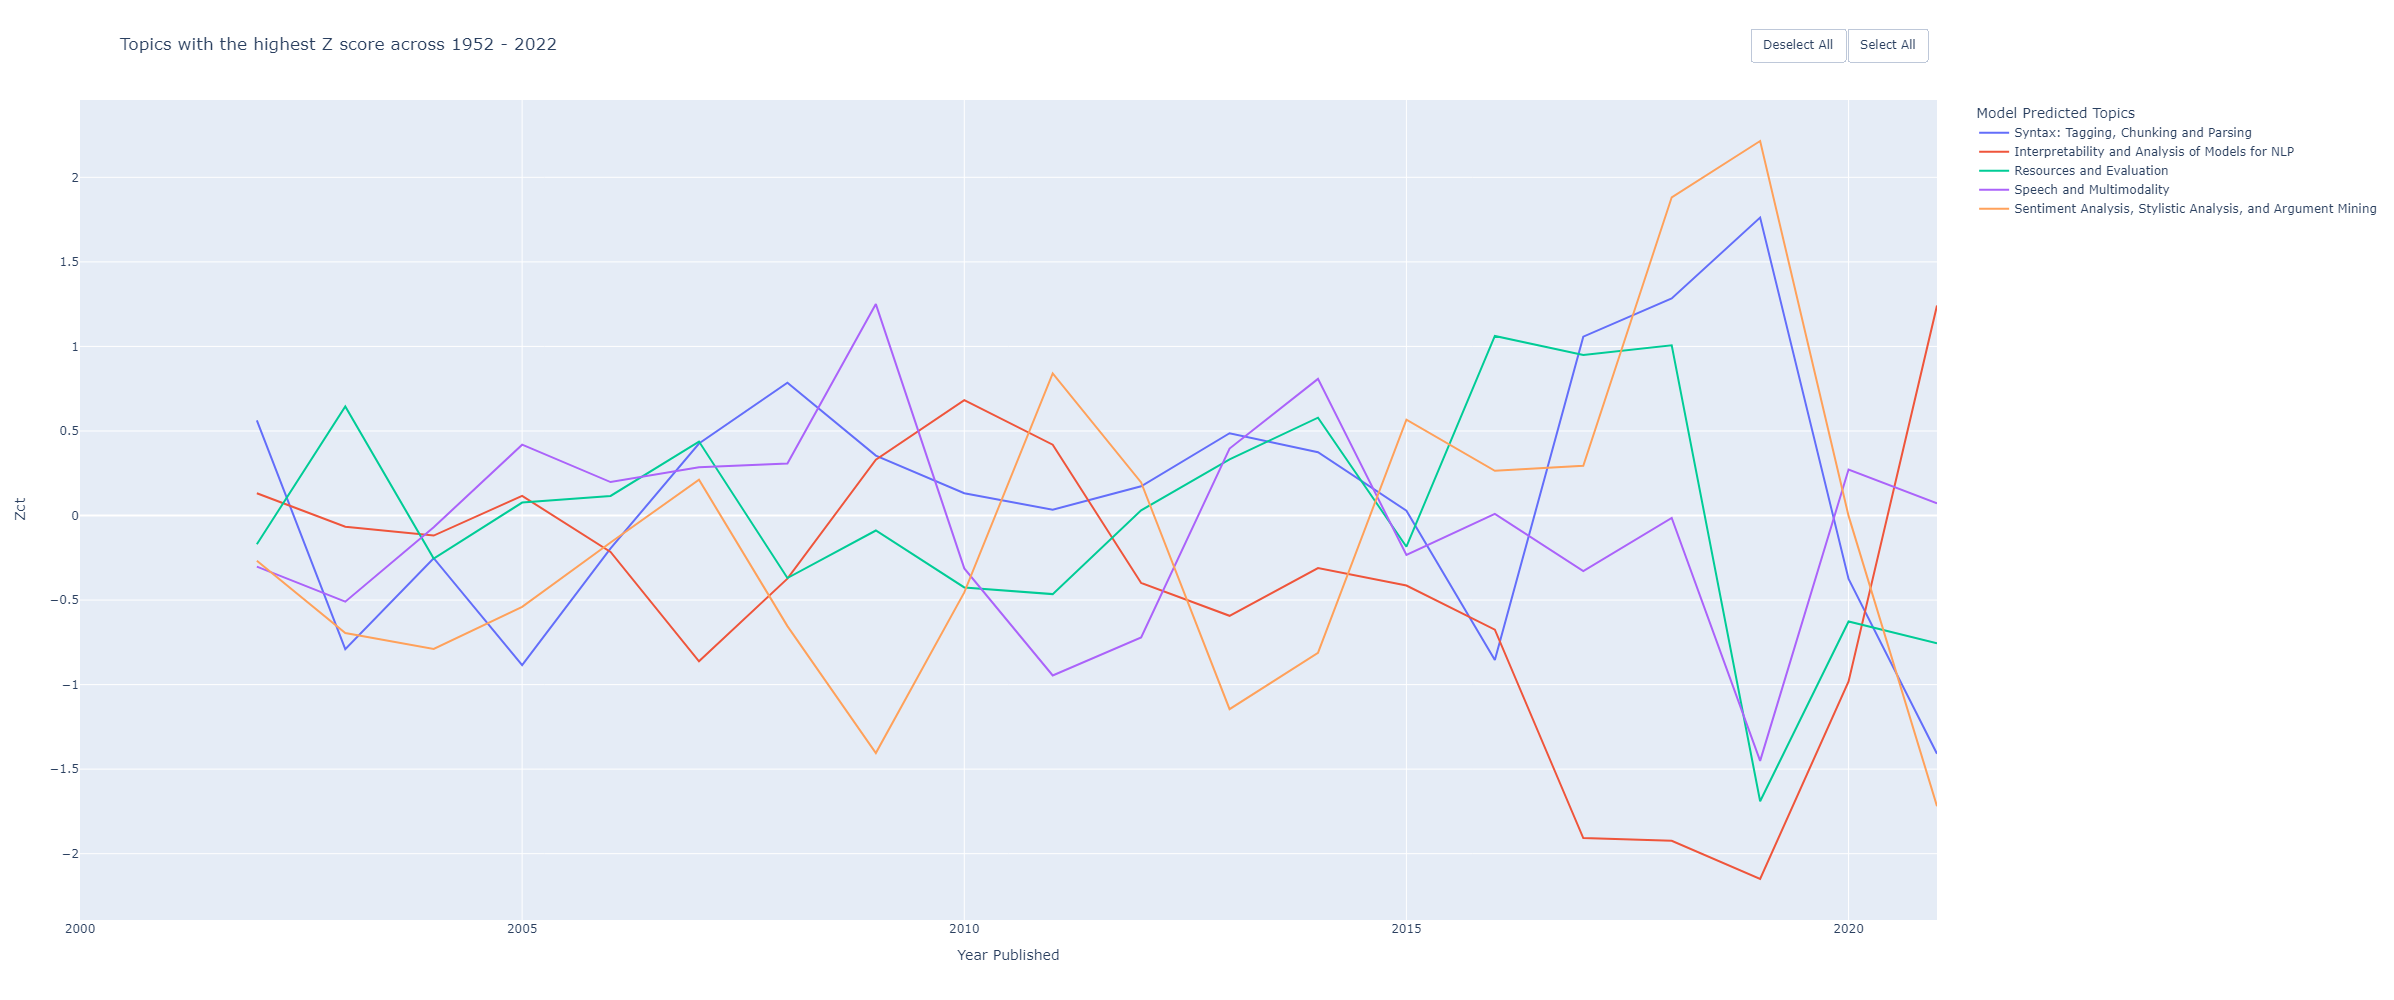

In [93]:
fig = px.scatter(pldf_plot_3, x="Year Published", y="Zct", color="Model Predicted Topics", title="Topics with the highest Z score across 1952 - 2022",
                 trendline="rolling", 
                 trendline_options=dict(window=3, win_type="gaussian", function_args=dict(std=2)),
                 width=2300,
                 height=1000)

fig.update_layout(dict(updatemenus=[
                        dict(
                            type = "buttons",
                            direction = "left",
                            buttons=list([
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle"
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle"
                                )
                            ]),
                            pad={"r": 10, "t": 10},
                            showactive=False,
                            x=1,
                            xanchor="right",
                            y=1.1,
                            yanchor="top"
                        ),
                    ]
              ))
fig.data = [t for t in fig.data if t.mode == "lines"]
fig.update_traces(showlegend=True)
fig.show()

### Plot top 5 topics with the widest z score with smoothing

In [64]:
Topics_of_interest = list(z_c_t.groupby('Model Predicted Topics')['Zct'].agg(np.ptp).reset_index(name = "Diff z score").nlargest(5, "Diff z score")['Model Predicted Topics'])

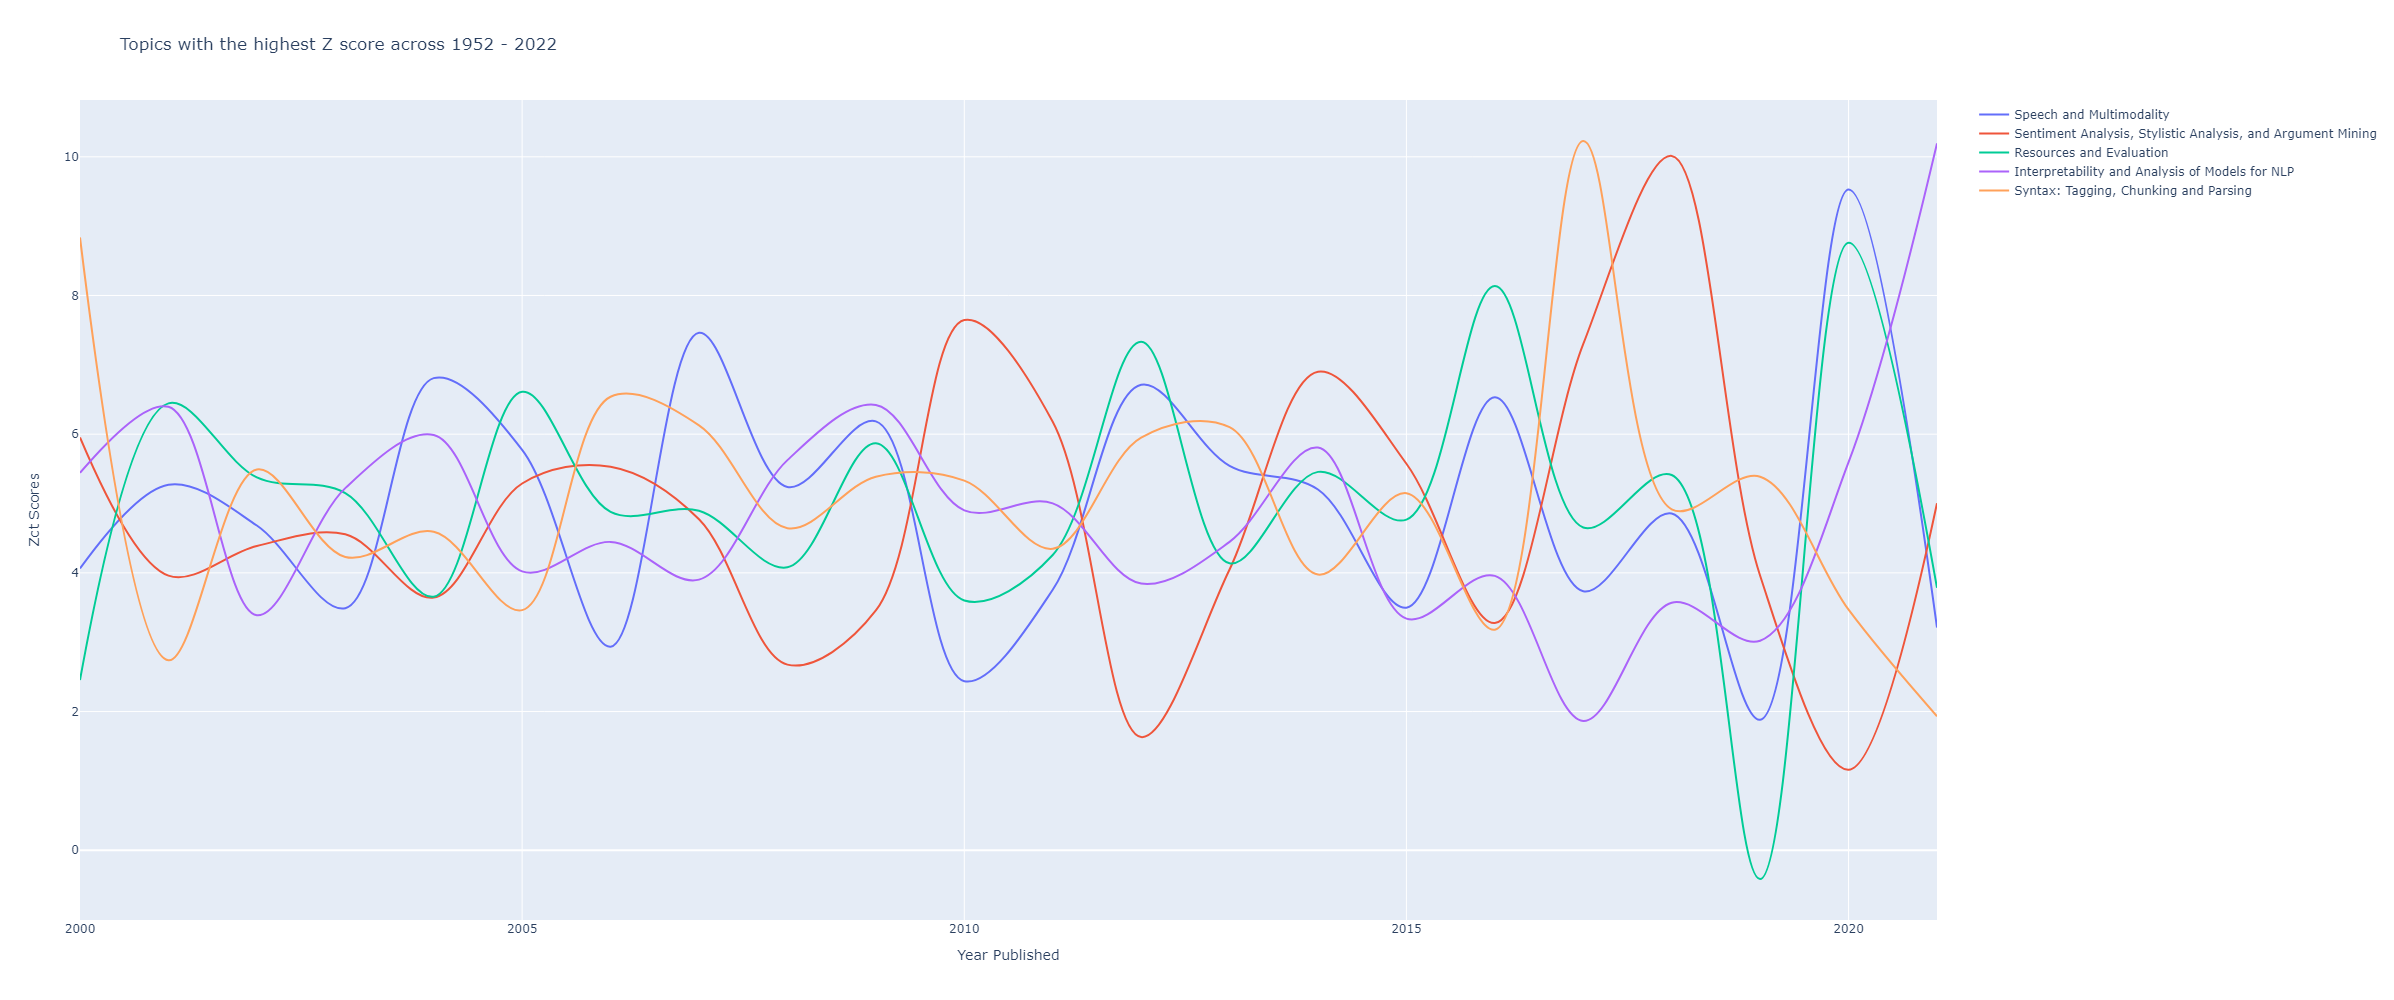

In [79]:
import plotly.graph_objs as go

fig = go.Figure()

for topic in  z_c_t['Model Predicted Topics'].unique():
    
    df = z_c_t[z_c_t['Model Predicted Topics'] == topic]
    
    x = df['Year Published'].to_numpy()
    y = df['Zct'].to_numpy()
    
    if topic in Topics_of_interest:
        fig.add_trace(go.Scatter(x=x, y=y + 5, name = topic,
                                 hoverinfo='name + y',
                                 line_shape='spline'))

fig.update_layout(
    width=2300,
    height=1000,
    yaxis=dict(title_text="Zct Scores"),
    xaxis=dict(title_text="Year Published"),
    title="Topics with the highest Z score across 1952 - 2022"
)